# Machine Learning Project

This project aim to construct a tree predictor in order to predict either a mushroom is edible or poisonous. The github repository can be find here : https://github.com/theot-student/MachineLearning_Project

In [1]:
import numpy as np
import pandas as pd
import math
import random

## Dataset

For this project we use the "Secondary Mushrooms" Dataset :
Wagner,Dennis, Heider,D., and Hattab,Georges. (2023). Secondary Mushroom. UCI Machine Learning Repository. https://doi.org/10.24432/C5FP5Q.

In [2]:
!pip install ucimlrepo

This dataset has 20 features for each point.

In [53]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
secondary_mushroom = fetch_ucirepo(id=848)

# data (as pandas dataframes)
X = secondary_mushroom.data.features
y = secondary_mushroom.data.targets

#we shuffle our data
shuffleX = X.sample(frac=1)
shuffleY = y.reindex(shuffleX.index)

X_np = shuffleX.to_numpy()
Y_np = shuffleY.to_numpy()

# metadata
print(secondary_mushroom.metadata)

# variable information
print(secondary_mushroom.variables)


{'uci_id': 848, 'name': 'Secondary Mushroom', 'repository_url': 'https://archive.ics.uci.edu/dataset/848/secondary+mushroom+dataset', 'data_url': 'https://archive.ics.uci.edu/static/public/848/data.csv', 'abstract': 'Dataset of simulated mushrooms for binary classification into edible and poisonous.', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Tabular'], 'num_instances': 61068, 'num_features': 20, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2021, 'last_updated': 'Wed Apr 10 2024', 'dataset_doi': '10.24432/C5FP5Q', 'creators': ['Dennis Wagner', 'D. Heider', 'Georges Hattab'], 'intro_paper': {'title': 'Mushroom data creation, curation, and simulation to support classification tasks', 'authors': 'Dennis Wagner, D. Heider, Georges Hattab', 'published_in': 'Scientific Reports', 'year': 2021, 'url': 'https://www.semanticscholar.org/

The targets are used for binary classification with p if a mushroom is poisonous and e if it's edible

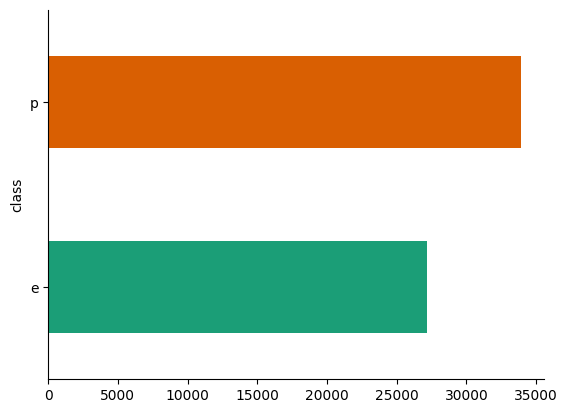

In [54]:
from matplotlib import pyplot as plt
import seaborn as sns
y.groupby('class').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

We need to split our dataSet in a training set and a test set

In [55]:
nbDataTraining = int(len(X) * 0.8)

In [56]:
nbDataTraining

48855

In [57]:
X_training = X_np[:nbDataTraining]
Y_training = Y_np[:nbDataTraining]
X_test = X_np[nbDataTraining:]
Y_test = Y_np[nbDataTraining:]

In [58]:
np.unique(Y_training, return_counts = True)

(array(['e', 'p'], dtype=object), array([21789, 27066]))

## Tree predictor algorithm

First we need to define a node class to construct the tree

In [157]:
class Node:
  #Create a node for tree classifier
  #
  #VAR :
  #     rightChildren, leftChildren : Node                    | childrens for the tree construction
  #     isALeaf                     : Boolean                 | boolean to check if the node is a leaf
  #     label                       : Integer/Char            | if the node is a leaf, this represents the label in which the datapoint in the nodes are classified
  #     criterion                   : function                | if the node is not a leaf, this represents the criterion function to split the data points to the left and right children. It returns a boolean
  #     criterionAlreadyUsed        : set<function>           | set of the criteria already used before in the tree
  #     errorVariationDict          : dict<function, double>  | dictionnary keeping the variation error for every possible splitting of this leaf considering all criteria not already used before
  #In our case, in a node, we consider that our right children contains always the result "True" to the criterion (i.e. that all the dataPoint that returns True with the criterion goes to the right children)


  def __init__(self, rightChildren = None, leftChildren = None, isALeaf = None, label = None, criterion = None, criterionAlreadyUsed = set(), errorVariationDict = dict()):
    self.rightChildren = rightChildren
    self.leftChildren = leftChildren
    self.isALeaf = isALeaf
    self.label = label
    self.criterion = criterion
    self.criterionAlreadyUsed = criterionAlreadyUsed
    self.errorVariationDict = errorVariationDict


In [180]:
class BinaryTreePredictor:
  #This class is used to train a tree predictor for a binary classification problem of machine learning. We will use a greedy (or greedy over all leaves) process to find the split at each iteration
  #
  #VAR :
  #     decisionCriterionList : set                       | set of criterion possible over our features. Need to define what is a criterion, probably a function
  #     splittingCriterion    : function                  | function to compute the training error and chose the best splitting reducing training error (phi function in lecture notes)
  #     stoppingCriterion     : function                  | function that stop the grown of the tree (for exemple when the depth max is reached)
  #     labels                : array                     | array containing all the possible labels
  #     dictLeaves            : dict<Node, set<tuple>>    | dictionnary containing all the leaves as keys and the set of exemples rooted to this leaf as value
  #     nbExemples            : integer                   | integer of the number of exemples
  #     tree                  : Node                      | root of the tree classifier created by the algorithm

  def __init__(self, decisionCriterionSet, splittingCriterion, stoppingCriterion):
    self.decisionCriterionSet = decisionCriterionSet
    self.splittingCriterion = splittingCriterion
    self.stoppingCriterion = stoppingCriterion
    self.labels = None
    self.dictLeaves = None
    self.nbExemples = None
    self.tree = None

  def leafTrainingError(self, leaf, dataPoints):
    positifPoints = 0
    nbPoint = len(dataPoints)
    if nbPoint != 0:
      for point in dataPoints:
        if leaf.label == point[0]:
          positifPoints += 1
      if (positifPoints == 0):
        return 10000
      elif (positifPoints / nbPoint == 1):
        return 0
      else:
        return self.splittingCriterion(positifPoints / nbPoint) * nbPoint
    else:
      return 10000

  #not used anymore
  def setLabel(self, leaf, dataPoints):
    count0 = 0
    count1 = 0

    for point in dataPoints:
      npPoint = np.array(point)
      if npPoint[0] == self.labels[0]:
        count0 += 1
      else:
        count1 += 1
    if count1 < count0:
      leaf.label = self.labels[0]
    else:
      leaf.label = self.labels[1]

  def testSplit(self, leaf, criterion, points = None):
    newRightLeaf = Node()
    newLeftLeaf = Node()
    rightPoints = set()
    leftPoints = set()

    if points == None:
      points = self.dictLeaves[leaf]

    countersRight = [0,0]
    countersLeft = [0,0]

    for point in points:
      if criterion(np.array(point)):
        rightPoints.add(point)
        if point[0] == self.labels[0]:
          countersRight[0] += 1
        else:
          countersRight[1] += 1
      else:
        leftPoints.add(point)
        if point[0] == self.labels[0]:
          countersLeft[0] += 1
        else:
          countersLeft[1] += 1

    newRightLeaf.isALeaf = True
    if countersRight[1] < countersRight[0]:
      newRightLeaf.label = self.labels[0]
    else:
      newRightLeaf.label = self.labels[1]

    newLeftLeaf.isALeaf = True
    if countersRight[1] < countersRight[0]:
      newLeftLeaf.label = self.labels[0]
    else:
      newLeftLeaf.label = self.labels[1]

    errorVariation = self.leafTrainingError(leaf, points)
    errorVariation -= self.leafTrainingError(newRightLeaf, rightPoints)
    errorVariation -= self.leafTrainingError(newLeftLeaf, leftPoints)

    return errorVariation

  def calculVariationErrorDict(self,leaf, points = None):
    errorVariationDict = dict()
    for criterion in self.decisionCriterionSet:
      if not(criterion in leaf.criterionAlreadyUsed):
        errorVariationDict[criterion] = self.testSplit(leaf, criterion, points)
      else:
        errorVariationDict[criterion] = -100
    return errorVariationDict


  def splitLeaf(self, leaf, criterion):
    newRightLeaf = Node()
    newLeftLeaf = Node()
    rightPoints = set()
    leftPoints = set()

    countersRight = [0,0]
    countersLeft = [0,0]

    for point in self.dictLeaves[leaf]:
      if criterion(np.array(point)):
        rightPoints.add(point)
        if point[0] == self.labels[0]:
          countersRight[0] += 1
        else:
          countersRight[1] += 1
      else:
        leftPoints.add(point)
        if point[0] == self.labels[0]:
          countersLeft[0] += 1
        else:
          countersLeft[1] += 1



    newRightLeaf.isALeaf = True
    if countersRight[1] < countersRight[0]:
      newRightLeaf.label = self.labels[0]
    else:
      newRightLeaf.label = self.labels[1]
    newRightLeaf.criterionAlreadyUsed = leaf.criterionAlreadyUsed.copy()
    newRightLeaf.criterionAlreadyUsed.add(criterion)
    newRightLeaf.errorVariationDict = self.calculVariationErrorDict(newRightLeaf, rightPoints)

    newLeftLeaf.isALeaf = True
    if countersRight[1] < countersRight[0]:
      newLeftLeaf.label = self.labels[0]
    else:
      newLeftLeaf.label = self.labels[1]
    newLeftLeaf.criterionAlreadyUsed = leaf.criterionAlreadyUsed.copy()
    newLeftLeaf.criterionAlreadyUsed.add(criterion)
    newLeftLeaf.errorVariationDict = self.calculVariationErrorDict(newLeftLeaf, leftPoints)

    leaf.rightChildren = newRightLeaf
    leaf.leftChildren = newLeftLeaf
    leaf.isALeaf = False
    leaf.label = None
    leaf.criterion = criterion
    leaf.errorVariationDict = dict()

    self.dictLeaves.pop(leaf)
    self.dictLeaves[newRightLeaf] = rightPoints
    self.dictLeaves[newLeftLeaf] = leftPoints



  def computeTrainingError(self):
    trainingError = 0
    for leaf in self.dictLeaves.keys():
      trainingError += self.leafTrainingError(leaf, self.dictLeaves[leaf])
    return (trainingError / self.nbExemples)


  def growTree (self):
    leafToSplit = None
    criterionToUse = None
    errorVariation = 0
    for leaf in self.dictLeaves.keys():
      for criterion in  leaf.errorVariationDict.keys():
        if leaf.errorVariationDict[criterion] > errorVariation:
          leafToSplit = leaf
          criterionToUse = criterion
          errorVariation = leaf.errorVariationDict[criterion]
    if errorVariation != 0:
      self.splitLeaf(leafToSplit, criterionToUse)
    return errorVariation


  def growAllLeaves (self):
    totalErrorVariation = 0
    for leaf in self.dictLeaves.copy().keys():
      leafToSplit = None
      criterionToUse = None
      errorVariation = 0
      for criterion in  leaf.errorVariationDict.keys():
        if leaf.errorVariationDict[criterion] > errorVariation:
          leafToSplit = leaf
          criterionToUse = criterion
          errorVariation = leaf.errorVariationDict[criterion]
      if errorVariation > 0:
        self.splitLeaf(leafToSplit, criterionToUse)
        totalErrorVariation += errorVariation
    return errorVariation

  #data points are stored in np_array
  def train(self, training_features, training_target, method = 'greedy'):
    X = training_features
    Y = training_target

    self.nbExemples = len(X)
    dataPoints = np.concatenate((Y, X),1)
    dataPointsSet = set()
    for point in dataPoints:
      pointTuple = tuple(point)
      dataPointsSet.add(pointTuple)

    Y = Y.reshape(len(Y))
    self.labels, counts = np.unique(Y, return_counts=True)
    #init by a single node with the majority of class in the training set
    majorityLabel = self.labels[np.argmax(counts)]
    self.tree = Node(isALeaf = True, label = majorityLabel)

    #we use a dict to store the datapoint in each leaves of our tree
    self.dictLeaves = dict()
    self.dictLeaves[self.tree] = dataPointsSet

    trainingError = self.computeTrainingError()
    print('training error = '+ str(trainingError))

    self.tree.errorVariationDict = self.calculVariationErrorDict(self.tree)
    variationError = 1
    #then we have the loop to train the tree
    while not(self.stoppingCriterion(self.tree, self.dictLeaves)) and (variationError > 0):
      if method == 'greedy':
        variationError = self.growTree()
      if method == 'greedyAllLeaves':
        variationError = self.growAllLeaves()
      trainingError = self.computeTrainingError()
      print('training error = '+ str(trainingError))

  def treeDescent (self, point):
    node = self.tree
    while not(node.isALeaf):
      if node.criterion(point):
        node = node.rightChildren
      else:
        node = node.leftChildren
    return node

  def predict(self, point):
    return self.treeDescent(point).label

  def evaluateAccuracy(self, test_features, test_target):
    rightExemples = 0
    dataPoints = np.concatenate((test_target, test_features),1)
    for i in range(len(test_features)):
      label = self.predict(dataPoints[i])
      if label == test_target[i]:
        rightExemples +=1
    return rightExemples / len(test_features)



### Criterion

Definition CRITERION :
function which take in input a set of dataPoint (i.e np.array)
and which output a boolean
should make a class for that

We need to choose the criterion we can use to differientiate our features

In [166]:
print(secondary_mushroom.variables[1:])

                    name     role         type demographic description units  \
1           cap-diameter  Feature   Continuous        None        None  None   
2              cap-shape  Feature  Categorical        None        None  None   
3            cap-surface  Feature  Categorical        None        None  None   
4              cap-color  Feature  Categorical        None        None  None   
5   does-bruise-or-bleed  Feature  Categorical        None        None  None   
6        gill-attachment  Feature  Categorical        None        None  None   
7           gill-spacing  Feature  Categorical        None        None  None   
8             gill-color  Feature  Categorical        None        None  None   
9            stem-height  Feature   Continuous        None        None  None   
10            stem-width  Feature   Continuous        None        None  None   
11             stem-root  Feature  Categorical        None        None  None   
12          stem-surface  Feature  Categ

In [167]:
def unique_no_nan(x):
    return x.dropna().unique()

In [168]:
def createCategoricalSingleCriterion(X, featureIndex, featureName, criterionSet):
  uniquesCategories = unique_no_nan(X[featureName])
  halfCategory = len(uniquesCategories) // 2
  setCategories = set()
  for i in range(halfCategory):
    setCategories.add(uniquesCategories[i])
  def criterionFunction(x, featureIndex=featureIndex, setCategories=setCategories):
      return x[featureIndex] in setCategories
  criterionSet.add(criterionFunction)

In [169]:
def createCategoricalSingleCriterions(X, featureIndex, featureName, criterionSet):
  uniquesCategories = unique_no_nan(X[featureName])
  for i in range(len(uniquesCategories)):
    def criterionFunction(x, featureIndex=featureIndex, i=i):
      return x[featureIndex] == uniquesCategories[i]
    criterionSet.add(criterionFunction)

In [170]:
def createCategoricalPairCriterions(X, featureIndex, featureName, criterionSet):
  uniquesCategories = unique_no_nan(X[featureName])
  for i in range(len(uniquesCategories)-1):
    def criterionFunction(x, featureIndex=featureIndex, i=i):
      return (x[featureIndex] == uniquesCategories[i]) or (x[featureIndex] == uniquesCategories[i+1])
    criterionSet.add(criterionFunction)

In [171]:
criterionSet = set()

for index, feature in secondary_mushroom.variables[1:].iterrows():
  if (feature.type == 'Categorical'):
    createCategoricalSingleCriterions(X, index, feature['name'], criterionSet)

In [172]:
print(len(criterionSet))

116


We now try to find good criterion for continous features

In [173]:
def continousCriterions(X, featureIndex, featureName, criterionSet, numberOfCriterions):
  min = unique_no_nan(X[featureName]).min()
  max = unique_no_nan(X[featureName]).max()
  partition = np.linspace(min, max, numberOfCriterions)

  for i in range(len(partition)-1):
    def criterionFunction(x, featureIndex=featureIndex, i=i):
      return ((partition[i] <= float(x[featureIndex])) and (float(x[featureIndex]) <= partition[i+1]))
    criterionSet.add(criterionFunction)

### Splitting Criterion

we use two differents splitting criterion (phi function in the lecture) :


*  GiniIndex
*  ScaledEntropy

In [174]:
def giniIndex(p):
  return 2*p*(1-p)

In [175]:
def scaledEntropy(p):
  return - ((p / 2) * math.log2(p) + ((1-p) / 2) * math.log2(1 - p))

### Stop Criterion

First we can say that the depth of the tree should not exceed a treshold

In [176]:
def stopDepth(tree, depthMax):
  if (depthMax == 0) and (tree.isALeaf):
    return True
  elif (depthMax != 0) and (tree.isALeaf):
    return False
  else:
    if stopDepth(tree.rightChildren, depthMax-1):
      return True
    else:
      return stopDepth(tree.leftChildren, depthMax-1)

But we can also stop whenever the new split does not contain enough point to be relevant.

In [177]:
def stopHomogeneity(dictLeaves, nbPointMin):
  for leaf in dictLeaves.keys():
    if len(dictLeaves[leaf]) < nbPointMin:
      return True
  return False


## Test on the dataSet

### 1) First test (dumb test)
First we learn a first exemple for the tree with the following parameters:

*   maximum depth = 5
*   splitting critarion = gini Index
*   for the Criterions of features, we use 1 criterion for each categorical feature


In [184]:
depthMax = 5

In [185]:
treePredictor1 = BinaryTreePredictor(criterionSet, giniIndex, lambda tree, dictLeaves : stopDepth(tree, depthMax))
treePredictor1.train(X_training, Y_training)

training error = 0.3007225723187175
training error = 0.2907574483364774
training error = 0.27993957657955537
training error = 0.27115239302556043
training error = 0.263730716513133
training error = 0.25823148368545606
training error = 0.25444914110906697
training error = 0.2506873801989549
training error = 0.2471664679279027


In [186]:
accuracy1 = treePredictor1.evaluateAccuracy(X_test, Y_test)

In [187]:
accuracy1 * 100

38.06287866382839

### 2) Second test : comparing the splitting criterion
We now use


*   maximum depth = 4
*   splitting critarion = gini Index
*   for the Criterions of features, we use all pair of category in each categorical feature (the function is to see if the feature of the point belong to the pair)

In [188]:
criterionSet2 = set()

for index, feature in secondary_mushroom.variables[1:].iterrows():
  if (feature.type == 'Categorical'):
    createCategoricalPairCriterions(X, index, feature['name'], criterionSet2)
  elif (feature.type == 'Continuous'):
    print()

In [189]:
depthMax2 = 4

In [190]:
treePredictor2 = BinaryTreePredictor(criterionSet2, giniIndex, lambda tree, dictLeaves : stopDepth(tree, depthMax2))
treePredictor2.train(X_training, Y_training)

training error = 0.3007225723187175
training error = 0.28856732591363954
training error = 0.27584949909199674
training error = 0.268246379146702
training error = 0.26065984250671653
training error = 0.2539235458509018


In [191]:
accuracy = treePredictor2.evaluateAccuracy(X_test, Y_test)
accuracy * 100

55.853938103815295


We keep the same parameters but change the splitting criterion by the scaled Entropy

In [192]:
treePredictor3 = BinaryTreePredictor(criterionSet2, scaledEntropy, lambda tree, dictLeaves : stopDepth(tree, depthMax2))
treePredictor3.train(X_training, Y_training)

training error = 0.30175907486879777
training error = 0.288917688736122
training error = 0.2794762168715445
training error = 0.27266602601575635
training error = 0.26604130043363816
training error = 0.2605018701541382


In [193]:
accuracy = treePredictor3.evaluateAccuracy(X_test, Y_test)
accuracy * 100

55.853938103815295

### 3) Third test : ading continuous criterion

In [194]:
criterionSet4 = set()

for index, feature in secondary_mushroom.variables[1:].iterrows():
  if (feature.type == 'Categorical'):
    createCategoricalSingleCriterions(X, index, feature['name'], criterionSet4)
  elif (feature.type == 'Continuous'):
    continousCriterions(X, index, feature['name'], criterionSet4, 4)

In [195]:
treePredictor4 = BinaryTreePredictor(criterionSet4, giniIndex, lambda tree, dictLeaves : stopDepth(tree, 4))
treePredictor4.train(X_training, Y_training, 'greedyAllLeaves')

training error = 0.3007225723187175
training error = 0.2907574483364774
training error = 0.27251790006712806
training error = 0.25618661302663187
training error = 0.24147025291814128


In [196]:
accuracy4 = treePredictor4.evaluateAccuracy(X_test, Y_test)
accuracy4 * 100

60.537088586867526

### 4) Fourth test : we compare the two growing method
We now use


*   minimum homogeneity = 50
*   splitting critarion = gini Index
*   for the criteria of features, we use a single criterion of category in each categorical feature and 4 criteria for continuous features

We want to see the differences of the two methods for growing the tree

In [242]:
criterionSet5 = set()

for index, feature in secondary_mushroom.variables[1:].iterrows():
  if (feature.type == 'Categorical'):
    createCategoricalSingleCriterions(X, index, feature['name'], criterionSet5)
  elif (feature.type == 'Continuous'):
    continousCriterions(X, index, feature['name'], criterionSet5, 4)

In [243]:
treePredictor5 = BinaryTreePredictor(criterionSet5, giniIndex, lambda tree, dictLeaves : stopHomogeneity(dictLeaves, 50))
treePredictor5.train(X_training, Y_training, 'greedyAllLeaves')

training error = 0.27547132222229087
training error = 0.2663355436677719
training error = 0.2550878439953288
training error = 0.24610190826580483
training error = 0.23160118687634032
training error = 0.21892336082980182
training error = 0.2049584944175781


In [244]:
accuracy5 = treePredictor5.evaluateAccuracy(X_test, Y_test)
accuracy5 * 100

44.62911413132471

In [245]:
criterionSet6 = criterionSet5
treePredictor6 = BinaryTreePredictor(criterionSet6, giniIndex, lambda tree, dictLeaves : stopHomogeneity(dictLeaves, 50))
treePredictor6.train(X_training, Y_training)

training error = 0.27547132222229087
training error = 0.2663355436677719
training error = 0.25901450247258256
training error = 0.25320797039729914
training error = 0.24565035956570527
training error = 0.24131570825856585
training error = 0.23738904978131203
training error = 0.23351803562126336
training error = 0.2303386319670229
training error = 0.2273916554166941
training error = 0.22373556528830604
training error = 0.2211271060375748
training error = 0.21871279257956042
training error = 0.21636863742992624
training error = 0.21297503731977838
training error = 0.21061647507127093
training error = 0.20835239258665164
training error = 0.2061360899466385
training error = 0.2039247341161523
training error = 0.2014419805820458
training error = 0.1991196599354932
training error = 0.19696252623335356
training error = 0.19498025462113033
training error = 0.19309853161137241
training error = 0.19144039123147139
training error = 0.18947883803199733
training error = 0.1874241190702184
training e

In [246]:
accuracy6 = treePredictor5.evaluateAccuracy(X_test, Y_test)
accuracy6 * 100

44.62911413132471

### 5) Fifth test : a more classical and reasonnable test


*   maximum depth = 8
*   splitting critarion = gini Index
*   for the Criterions of features, we use every single criterion for each categorical feature, and 2 criterion for continuous features
*greedyAllLeaves

In [203]:
criterionSet7 = set()

for index, feature in secondary_mushroom.variables[1:].iterrows():
  if (feature.type == 'Categorical'):
    createCategoricalSingleCriterions(X, index, feature['name'], criterionSet7)
  elif (feature.type == 'Continuous'):
    continousCriterions(X, index, feature['name'], criterionSet7, 2)

In [204]:
treePredictor7 = BinaryTreePredictor(criterionSet7, giniIndex, lambda tree, dictLeaves : stopDepth(tree, 8))
treePredictor7.train(X_training, Y_training, 'greedyAllLeaves')

training error = 0.3007225723187175
training error = 0.2907574483364774
training error = 0.27251790006712806
training error = 0.25618661302663187
training error = 0.24147025291814128
training error = 0.22377857904331233
training error = 0.20959656155516665
training error = 0.19888968413160507
training error = 0.1883673553154743


In [205]:
accuracy7 = treePredictor7.evaluateAccuracy(X_test, Y_test)
accuracy7 * 100

71.81922384149337

### 6) best computation for now
These parameters are the best I have tested for now :


*   maximum depth = 20
*   splitting critarion = gini Index
*   for the Criterions of features, we use every single criterion for each categorical feature, and 2 criterion for continuous features

In [206]:
criterionSet8 = set()

for index, feature in secondary_mushroom.variables[1:].iterrows():
  if (feature.type == 'Categorical'):
    createCategoricalSingleCriterions(X, index, feature['name'], criterionSet8)
  elif (feature.type == 'Continuous'):
    continousCriterions(X, index, feature['name'], criterionSet8, 2)

In [207]:
treePredictor8 = BinaryTreePredictor(criterionSet8, giniIndex, lambda tree, dictLeaves : stopDepth(tree, 20))
treePredictor8.train(X_training, Y_training, 'greedyAllLeaves')

training error = 0.3007225723187175
training error = 0.2907574483364774
training error = 0.27251790006712806
training error = 0.25618661302663187
training error = 0.24147025291814128
training error = 0.22377857904331233
training error = 0.20959656155516665
training error = 0.19888968413160507
training error = 0.1883673553154743
training error = 0.16915463439532563
training error = 0.14807203815631934
training error = 0.1347273575481141
training error = 0.12065153752145351
training error = 0.11053594458641317
training error = 0.09980902681870607
training error = 0.08964795985659388
training error = 0.08167213649962635
training error = 0.07510797243386541
training error = 0.07067242098655667
training error = 0.06678438049249037
training error = 0.0637211015227694


In [208]:
accuracy8 = treePredictor8.evaluateAccuracy(X_test, Y_test)
accuracy8 * 100

94.2197478303586

## Random Forest

To compute random forest, we need to things :


1.   create some subset of our training set by sampling over the rows and the columns (we remove some feature to construct each tree)
2.    train tree over all this subset and do a majority vote


In [247]:
class RandomForest:

  def __init__(self, decisionCriterionSet, splittingCriterion, stoppingCriterion, numberOfTrees):
    self.decisionCriterionSet = decisionCriterionSet
    self.splittingCriterion = splittingCriterion
    self.stoppingCriterion = stoppingCriterion
    self.numberOfTrees = numberOfTrees

  def samplingData(self, training_features, training_target, decisionCriterionSet):

    #first we take a proportion of our exemples
    #we chose that 67% of the datas are sampled which is the choice indicate in the google random forest course
    proba = 0.67
    nbExemplesSample = int(self.nbExemples * proba)
    training_features_sample = training_features[0:nbExemplesSample]
    training_target_sample =training_target[0:nbExemplesSample]
    for i in range(nbExemplesSample):
      rand = random.randint(0,self.nbExemples-1)
      training_features_sample[i] = training_features[rand]
      training_target_sample[i] = training_target[rand]

    #we now need to extract a random number of feature from this data.
    #A lazy way to do that (sorry I run out of time for this project) is to change every exemple of this features by a constant value (for exemple the first exemple value)
    #then when splitting the feature will never be considered as a good split

    nbFeatureDeleted = random.randint(self.nbFeatures//2,self.nbFeatures-2)
    featuresDeleted = random.sample(np.linspace(0,self.nbFeatures-1,self.nbFeatures,dtype=int).tolist(), nbFeatureDeleted)
    xTemp = training_features_sample[0]

    for x in training_features_sample:
      for j in featuresDeleted:
        x[j] = xTemp[j]

    return training_features_sample, training_target_sample, decisionCriterionSet

  def computeTrainingError(self):
    trainingError = 0
    for tree in self.forest:
      trainingError += tree.computeTrainingError()
    return trainingError / self.numberOfTrees

  def createForest(self,training_features, training_target, method = 'greedy'):
    self.forest = set()
    self.nbExemples = len(training_features)
    self.nbFeatures = len(training_features[1])

    for k in range(self.numberOfTrees):
      print('tree ' + str(k) + ' :')
      print()
      training_features_sample, training_target_sample, decisionCriterionSet = self.samplingData(training_features, training_target, self.decisionCriterionSet)
      tree = BinaryTreePredictor(decisionCriterionSet, self.splittingCriterion, self.stoppingCriterion)
      tree.train(training_features_sample,training_target_sample, method)
      self.forest.add(tree)

    print(self.computeTrainingError())

  def predict(self,point):
    predictions = []
    for tree in self.forest:
      label = tree.predict(point)
      predictions += label
    labels, count = np.unique(np.array(predictions), return_counts=True)
    return labels[np.argmax(count)]

  def evaluateAccuracy(self, test_features, test_target):pecies
    testError = 0
    dataPoints = np.concatenate((test_target, test_features),1)
    for i in range(len(test_features)):
      label = self.predict(dataPoints[i])
      if label == test_target[i]:
        testError +=1
    return testError / len(test_features)

In [248]:
criterionSetForest1 = set()

for index, feature in secondary_mushroom.variables[1:].iterrows():
  if (feature.type == 'Categorical'):
    createCategoricalSingleCriterions(X, index, feature['name'], criterionSetForest1)
  elif (feature.type == 'Continuous'):
    continousCriterions(X, index, feature['name'], criterionSetForest1, 2)

In [249]:
RandomForest1 = RandomForest(criterionSetForest1, giniIndex,  lambda tree, dictLeaves : stopDepth(tree, 5), 21)
RandomForest1.createForest(X_training, Y_training, 'greedyAllLeaves')

tree 0 :

training error = 0.0034488552802909313
training error = 0.0033518621510276684
training error = 0.003234615713426716
training error = 0.003117472360781284
training error = 0.0030339519183424524
training error = 0.002913659941869902
tree 1 :

training error = 0.10230582962187366
training error = 0.09914122835907781
training error = 0.09618536358851264
training error = 0.09329238828113322
training error = 0.08969952899379416
training error = 0.08608216694682996
tree 2 :

training error = 0.0883991886824102
training error = 0.08672513894205225
training error = 0.08537297463024622
training error = 0.08358552886725809
training error = 0.08239751504370356
training error = 0.08051168741823847
tree 3 :

training error = 0.11094791045608084
training error = 0.10702005034423671
training error = 0.10131461253728394
training error = 0.09448122711176773
training error = 0.0888604694111718
training error = 0.08309243876194407
tree 4 :

training error = 0.08689930095913521
training error = 0

In [250]:
accuracyRandomForest1 = RandomForest1.evaluateAccuracy(X_test, Y_test)
accuracyRandomForest1 * 100

55.98493532012445